# Introduction

This project will show how to use YOLO object detector to detect objects in both images and streams from a camera, using Python, OpenCV and deep learning.

## Requirements

- Python 3.x
- Numpy
- Matplotlib
- OpenCV >=4.0
- Configuration and pre-trained weights for YOLO v3.
- Raspberry Pi (optional)
- USB camera

## Outline

1. Brief introduction about Raspberry Pi, Python, OpenCV and YOLO.
2. Build YOLO object detector using OpenCV.
3. Use YOLO to detect objects from an image.
4. Use YOLO to detect objects from a camera. 

## Acknowledgements

I didn't create this from scratch, most of codes are based on: 

- [YOLO object detection with OpenCV](https://www.pyimagesearch.com/2018/11/12/yolo-object-detection-with-opencv/) from **pyimagesearch** by *Adrian Rosebrock*.

- [YOLO](https://pjreddie.com/darknet/yolo) by *Joseph Redmon, Ali Farhadi*

# What do we need

## Raspberry Pi: 

Raspberry Pi is a low cost, credit-card sized computer, which we can run a Linux system on. 

Raspberry Pi 3 Model B has the following specs:

- Quad Core 1.2GHz Broadcom BCM2837 64bit CPU
- 1GB RAM
- BCM43438 wireless LAN and Bluetooth Low Energy (BLE) on board
- 100 Base Ethernet
- 40-pin extended GPIO
- 4 USB 2 ports
- 4 Pole stereo output and composite video port
- Full size HDMI
- CSI camera port for connecting a Raspberry Pi camera
- DSI display port for connecting a Raspberry Pi touchscreen display
- Micro SD port for loading your operating system and storing data
- Upgraded switched Micro USB power source up to 2.5A

## Python and OpenCV

- Python: an interpreted, high-level, general-purpose programming language, from [OpenCV wikipedia](https://en.wikipedia.org/wiki/OpenCV) 
- OpenCV: Open source computer vision) is a library of programming functions mainly aimed at real-time computer vision. OpenCV supports the deep learning frameworks TensorFlow, Torch/PyTorch and Caffe, from [Pytho wikipedia](https://en.wikipedia.org/wiki/Python_(programming_language))


## YOLO

- You only look once (YOLO) is a state-of-the-art, real-time object detection system. 

source: [pjreddie.com](https://pjreddie.com/darknet/yolo/).

- We will use YOLO v3 pre-trained on the COCO dataset, which consists of 80 labels, including: *person, bicycle, car, motorbike, aeroplane, bus, train, truck*... and so on.

# Build YOLO object detector using OpenCV 

## Load YOLO model

All the files we need including sample images, pre-trained weights and configurations are included in the current folder. 

To see what is in the current folder, run *!tree*:

In [1]:
!tree

.
├── images
│   ├── dog.jpg
│   └── lane_following.png
├── LICENSE
├── Object detection with OpenCV and YOLO on a Raspberry Pi.ipynb
├── README.md
├── scripts
│   └── download_weights.sh
└── yolo_coco
    ├── coco.names
    ├── structure.png
    ├── yolov3.cfg
    └── yolov3.weights

3 directories, 10 files


- **yolo_coco/** : The YOLOv3 object detector pre-trained (on the COCO dataset) model files.
- **images/**: some example images we can perform object detection on. 
- **scripts/**: script to download YOLO weights. 
- **Object detection with OpenCV and YOLO on a Raspberry Pi.ipynb**: this file we will be working on.

In [2]:
# import the necessary packages
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
from IPython import display

%matplotlib inline

We would need to load the class labels first, then generate some random colors for each class

In [3]:
# load the COCO class labels the YOLO model was trained on
with open("yolo_coco/coco.names") as f:
    coco_labels = f.read().strip().split("\n")

# initialize a list of colors to represent each possible class label
np.random.seed(0)
colors = np.random.randint(0, 255, size=(len(coco_labels), 3), dtype="uint8")

print("%d labels are: %s..." %
      (len(coco_labels), ", ".join(coco_labels[0:10])))

80 labels are: person, bicycle, car, motorbike, aeroplane, bus, train, truck, boat, traffic light...


We need to use OpenCV's DNN function called [cv2.dnn.readNetFromDarknet](https://docs.opencv.org/4.0.0/d6/d0f/group__dnn.html#gafde362956af949cce087f3f25c6aff0d), which requires 
- path to the .cfg file with text description of the network architecture 
- path to the .weights file with learned network.

Both files are stored under the **yolo_coco** folder.

In [4]:
# load YOLO object detector trained on COCO dataset (80 classes)
yolo_v3 = cv2.dnn.readNetFromDarknet("yolo_coco/yolov3.cfg",
                                     "yolo_coco/yolov3.weights")

# 'YOLO' layers are not connected to following layers
all_layers = yolo_v3.getLayerNames()
yolo_layers = [
    all_layers[i - 1] for i in yolo_v3.getUnconnectedOutLayers().flatten()
]

There are 107 layers in YOLO v3, we can see their type and order by:

> yolo_v3.getLayerNames()

There are 3 'YOLO' layer in the network, each 'YOLO' layer is in charge of detect objects in different size, see image below

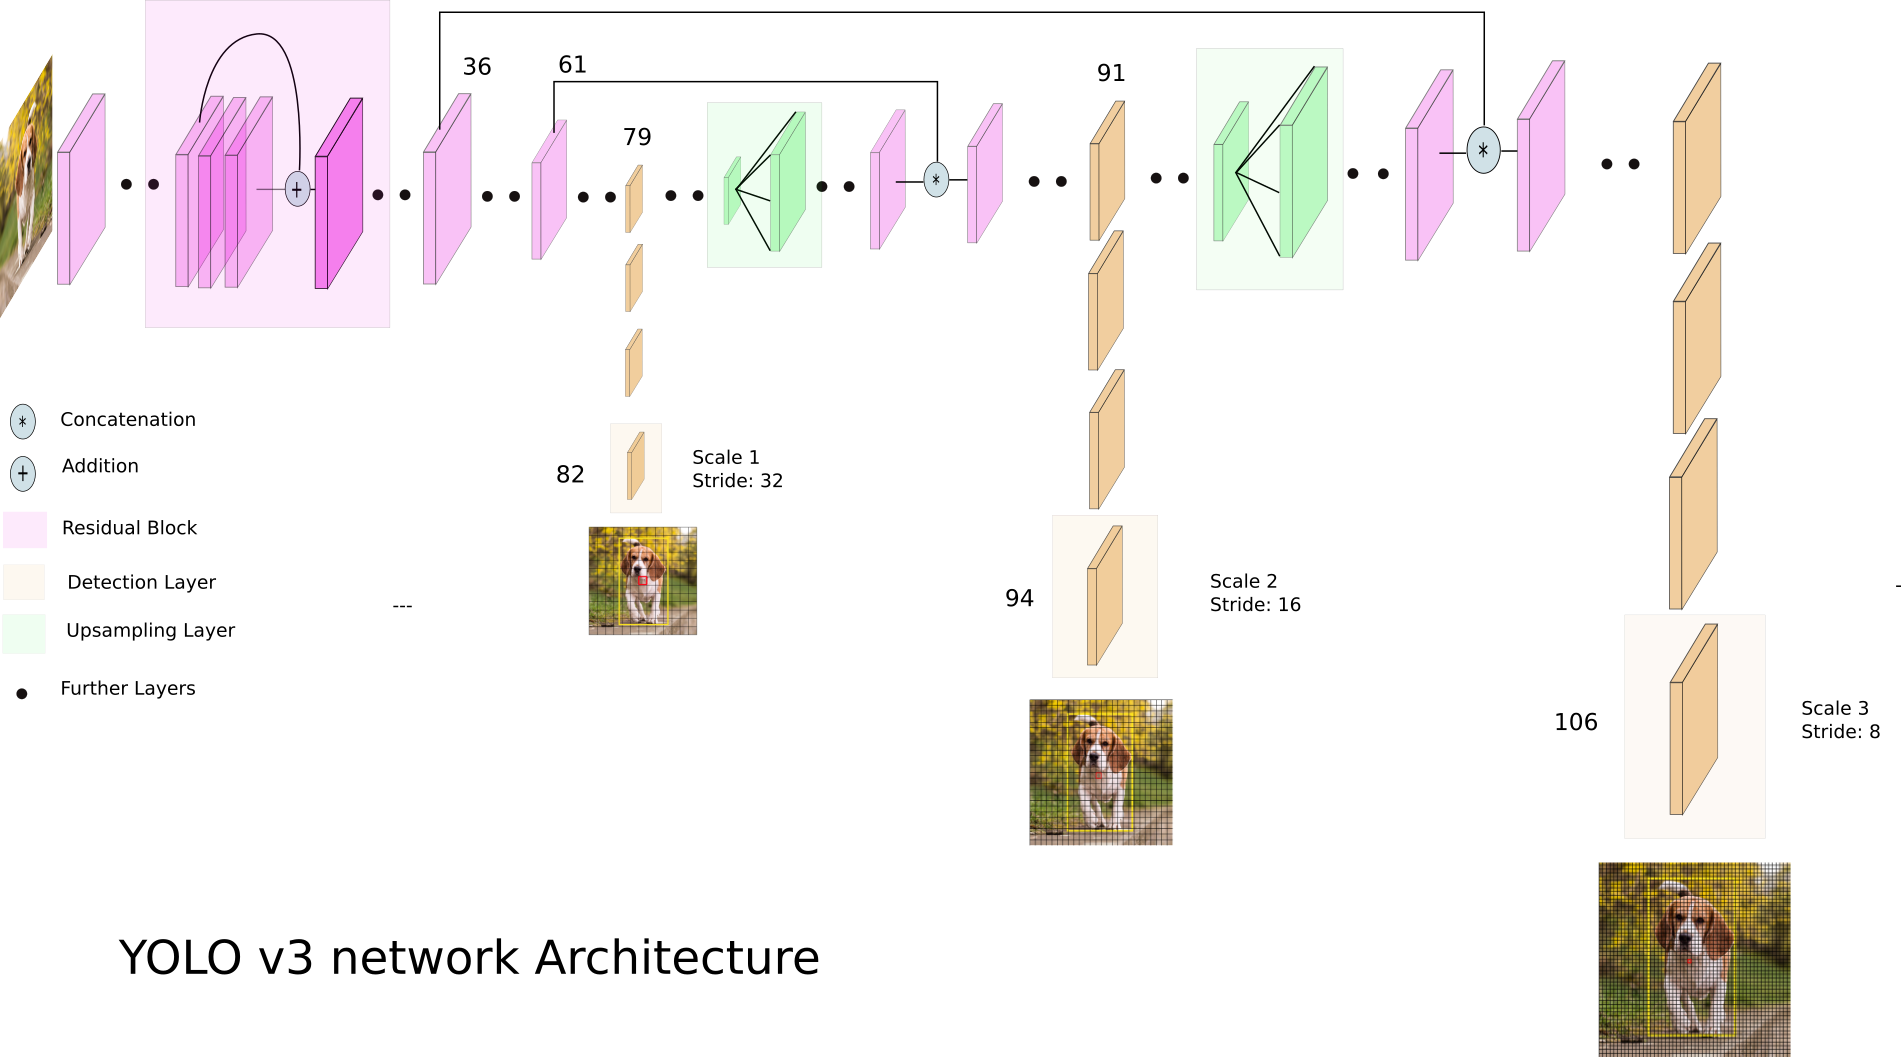
source: [What’s new in YOLO v3?
](https://towardsdatascience.com/yolo-v3-object-detection-53fb7d3bfe6b)

# Use YOLO to detect objects from an image.

Let's load an example image under the *images/* folder:

(360, 640, 3)


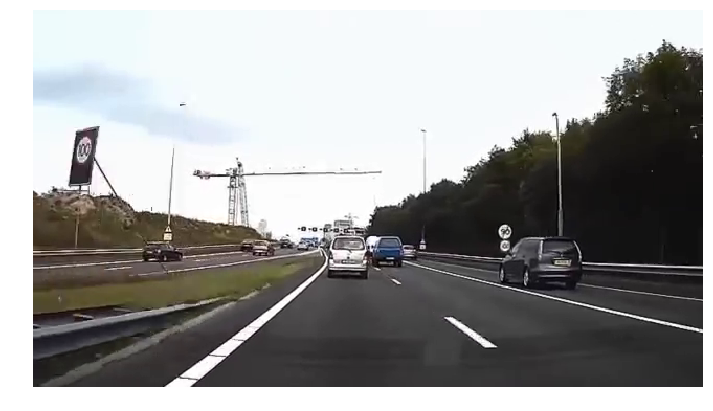

In [12]:
# plot an OpenCV image using Matplotlib
def plot_cv_image(image):
    %matplotlib inline
    # because OpenCV use BGR order, we need to convert it to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    fig, ax = plt.subplots(figsize=(12, 12))
    plt.imshow(image_rgb)
    ax.axis("off")


image = cv2.imread("images/lane_following.png")
plot_cv_image(image)
print(image.shape)

An image from file or camera typically has a dimension of (height, width, channel), for example (576, 768, 3), where 3 represents RGB channels. 

However, OpenCV YOLO model would need input of dimension of (number of images, channel, height, width). We can use [blobFromImage](https://docs.opencv.org/3.3.0/d6/d0f/group__dnn.html#ga0507466a789702eda8ffcdfa37f4d194) function to do the conversion for one image.

In [17]:
# detect a single image using the yolo_v3 model
def detect_image(single_image):
    # construct a blob from the input image
    blob = cv2.dnn.blobFromImage(single_image,
                                 scalefactor=1 / 255.0,
                                 size=(416, 416),
                                 swapRB=True,
                                 crop=False)
    # perform a forward of the YOLO object detector
    yolo_v3.setInput(blob)
    # output bounding boxes and associated probabilities
    yolo_outputs = yolo_v3.forward(outBlobNames=yolo_layers)
    # outputs is a list of lenght 3, correspoding results from 3 YOLO layers, merge them together
    yolo_outputs = np.vstack(yolo_outputs)
    return yolo_outputs


start_time = time.time()
yolo_outputs = detect_image(image)
end_time = time.time()
print("YOLO took %.2f seconds to detect %d objects." %
      (end_time - start_time, len(yolo_outputs)))

YOLO took 0.47 seconds to detect 10647 objects.


The outputs from YOLO model has a dimension of {{yolo_outputs.shape}}, which means YOLO detected {{yolo_outputs.shape[0]}} objects, each object has {{yolo_outputs.shape[1]}} values.

The first 4 values of each object is the bounding box: center (x, y), followed by width and height, relative to the size of the image.

The 5th value is the bounding box confidence.

The following 80 values are class confidences, remember we have 80 classes on the COCO dataset.

As we can see, there are two many object detected, of which some are low confidence boxes, and some are overlapping boxes. We will need to filter and remove them.

Low confidence boxes can be removed by setting a threshold, while overlapping boxes can be removed by non maximum suppression using an OpenCV function [NMSBoxes](https://docs.opencv.org/4.1.0/d6/d0f/group__dnn.html#ga9d118d70a1659af729d01b10233213ee).

In [18]:
# filter yolo detection result, return a 2d array, with 7 columns: x,y,w,h,conf,class, class_conf
def filter_yolo_outputs(yolo_outputs, image_shape):
    if len(yolo_outputs) == 0:
        return np.empty((0, 7))
    # only keep the boxes with confidence>confidence_threshold
    confidence_threshold = 0.5
    filtered = yolo_outputs[yolo_outputs[:, 4] > confidence_threshold]

    # scale the bounding box coordinates back to pixels
    image_h, image_w, _ = image_shape
    filtered[:, 0:4] = filtered[:, 0:4] * np.array(
        [image_w, image_h, image_w, image_h])

    # convert the center to the left-top corner
    filtered[:, 0] = filtered[:, 0] - filtered[:, 2] / 2
    filtered[:, 1] = filtered[:, 1] - filtered[:, 3] / 2

    # select the class with highest class confidence
    class_confidences = filtered[:, 5:].max(axis=1)
    class_ids = filtered[:, 5:].argmax(axis=1).astype(int)

    # apply non-maxima suppression to suppress weak, overlapping bounding boxes
    indices = cv2.dnn.NMSBoxes(filtered[:, 0:4].astype(int).tolist(),
                               class_confidences.tolist(),
                               score_threshold=0.5,
                               nms_threshold=0.3)
    if len(indices) == 0:
        return np.empty((0, 7))

    indices = indices.flatten()
    # create new array to save the filtered detection results
    detections = np.zeros([indices.size, 7])
    detections[:, :5] = filtered[indices, :5]  # x,y,w,h,conf
    detections[:, 5] = class_ids[indices]  # class id
    detections[:, 6] = class_confidences[indices]  # class conf

    return detections


detections = filter_yolo_outputs(yolo_outputs, image.shape)
print("After filter, there are %d objects." % len(detections))

After filter, there are 2 objects.


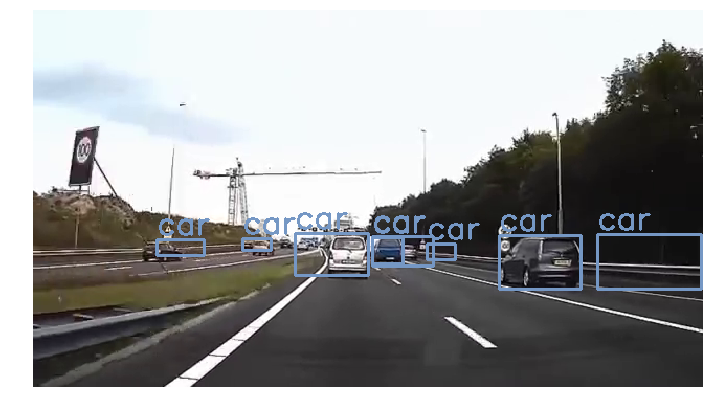

In [19]:
def mark_image(image, detections):
    # ensure at least one detection exists
    if detections.shape[0]==0:
        return image
    # loop over the indexes we are keeping
    for obj in detections:
        # extract the bounding box coordinates
        x, y, w, h, _, class_id, _ = obj.astype(int)
        # draw a bounding box rectangle and label on the image
        color = colors[class_id].tolist()
        cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
        text = coco_labels[class_id]
        cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
    return image

detection_image =  mark_image(image, detections)
plot_cv_image(detection_image)

# Use YOLO to detect objects from a camera.

Using OpenCV's VideoCapture functions, we can grab an image from a camera, detect it using YOLO, filter the detection results, then show it. 

Same steps as for a single image, which we can put in a for loop.

Because running on CPU, this would be very slow. 

<IPython.core.display.Javascript object>


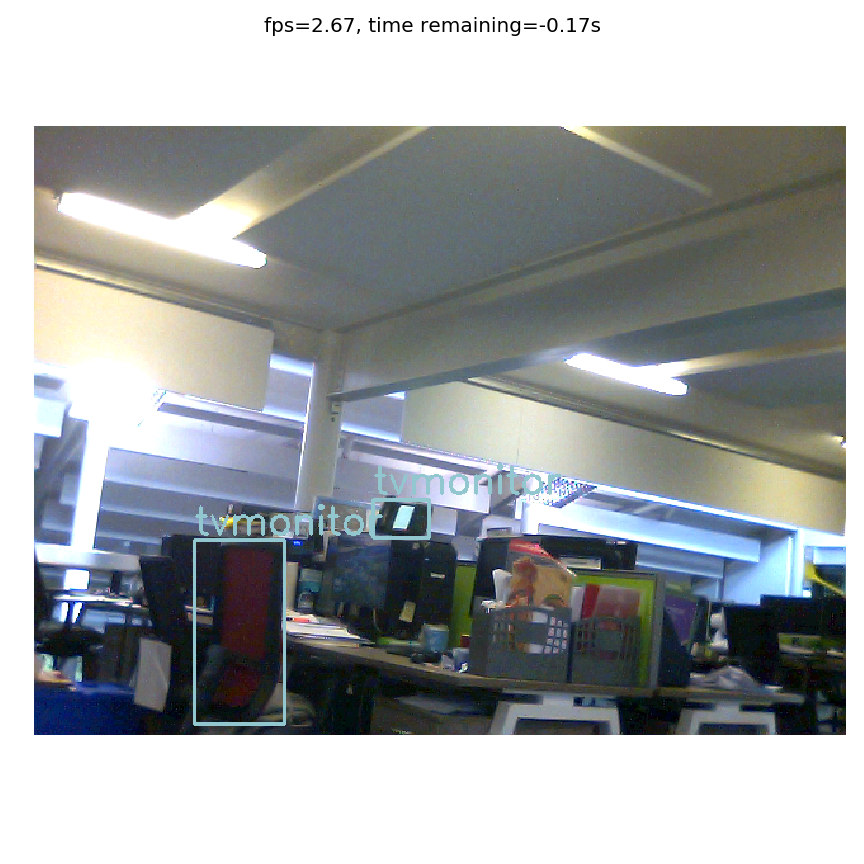

<IPython.core.display.Javascript object>


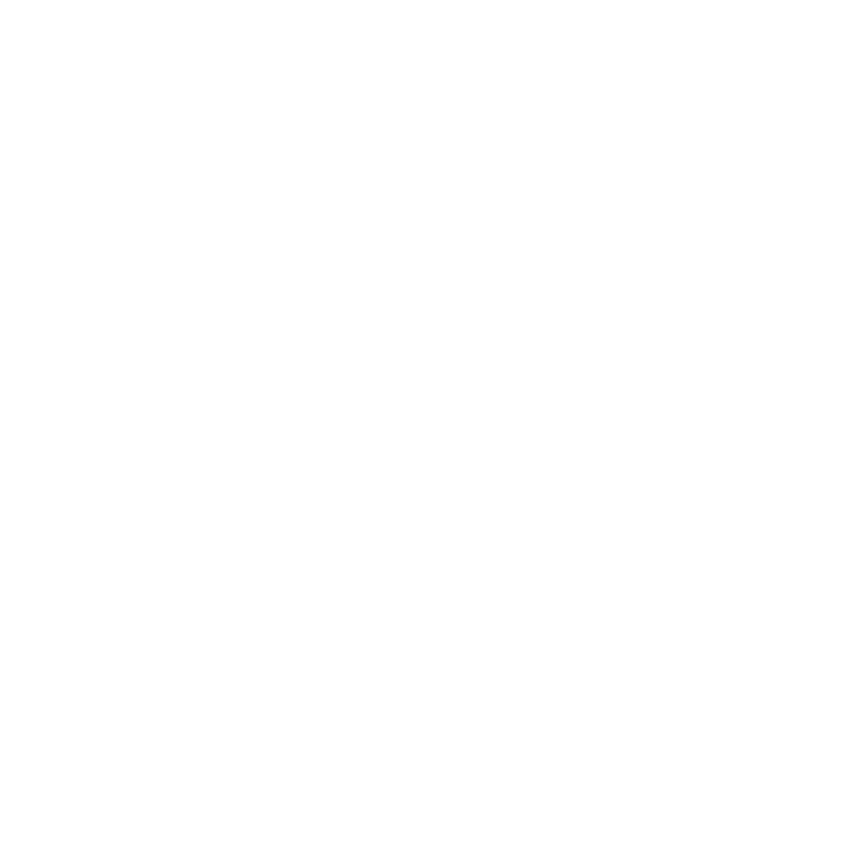

In [20]:
# detect images from camera for a certain time
def detect_camera(camera_id, run_time=50):
    fig, ax = plt.subplots(figsize=(12, 12))
    # turn on matplotlib interative plot mode
    plt.ion()
    fig.show()
    fig.canvas.draw()

    cap = cv2.VideoCapture(camera_id)
    # run in a loop for certain time
    total_time = 0
    while True:
        start_time = time.time()
        ret, frame = cap.read()
        if not ret or frame is None:
            print("Camera read failed")
            break
        yolo_outputs = detect_image(frame)
        detections = filter_yolo_outputs(yolo_outputs, frame.shape)
        detection_image = mark_image(frame.copy(), detections)
        image_rgb = cv2.cvtColor(detection_image, cv2.COLOR_BGR2RGB)
        end_time = time.time()
        delta_time = end_time - start_time
        total_time += delta_time

        ax.clear()
        fig.suptitle('fps=%.2f, time remaining=%.2fs' %
                     (1.0 / delta_time, run_time - total_time),
                     fontsize=20)
        fig.tight_layout()
        ax.imshow(image_rgb)
        ax.axis("off")
        fig.canvas.draw()
        time.sleep(0.1)
        if total_time > run_time:
            break


%matplotlib notebook
# Open camera 1 using OpenCV, if failed, check camera device id by run !ls /dev/|grep video
detect_camera(1)